In [1]:
#SageMath version 8.3 Notebook
import numpy as np
from aritmetic import Aritmetic

ar = Aritmetic()

#Finite field, generate a ring. It's the same as think we are working in module 17
F = FiniteField(17)
print(F)

print(type(F(3)))

f = F(3) * 123
print(f)

#square root an invertible integer
print(F(8).sqrt()) 

#bve carefull squaring root an non-invertible integer
print(F(3).sqrt())

#for more aritmetic modulation look at aritmetic.py or polinomial_aritmetic.py 
#it can seams not enought for you, see wikipedia or 
#https://www.johannes-bauer.com/compsci/ecc/ (especific to Elliptic Curve Cryptography (ECC))

Finite Field of size 17
<type 'sage.rings.finite_rings.integer_mod.IntegerMod_int'>
12
5
sqrt3


In [2]:
#Sage has a big amount of elliptic curves of the form: y^2 + cxy + dy = x^3 + ex^2 + ax + b
#we are going to work in a simple elliptic curve. The so-called short Weierstrass.
# y^2 = x^3 + 2*x + 3

#Take a prime
p = 263
print(factor(p))

#First generate a inite field Fp
F = FiniteField(p)

#set a = 2 and b = 3
a = 2
b = 3
EC = EllipticCurve(F, [a, b]) 

print(EC)

#n points on curve
print(EC.cardinality())

#first element of the group is (0, 1, 0) --> the neutral element. In other cases like z/zn it's zero for example.
print(EC.points()[0])

#list of first eigth points
print(EC.points()[:8])

263
Elliptic Curve defined by y^2 = x^3 + 2*x + 3 over Finite Field of size 263
270
(0 : 1 : 0)
[(0 : 1 : 0), (0 : 23 : 1), (0 : 240 : 1), (1 : 100 : 1), (1 : 163 : 1), (3 : 6 : 1), (3 : 257 : 1), (4 : 115 : 1)]


In [80]:
#choose a generation point like (200, 39)
#we choose that one because the order is equal (aprox) to the number of points.
#with this we ensure every single point will be used
#we know that IF the order is 270. It means that multiplying scalars with G there's 270 points --> 269 + 1 at infinity
   
G = EC.point((200, 39))
n = G.order()

#for use the order to sign after we need it to be prime

while int(list(factor(n))[0][0]) != int(n):
    G = EC.random_point()
    n = G.order()

print(n)

5


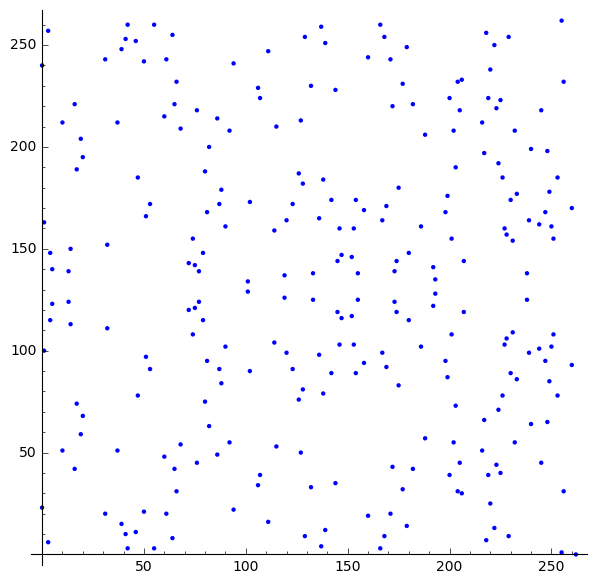

In [4]:
#Sage can plot everything you can wite (if you know what you are writing ;P).
#Let's plot all the points on the cue
plot(EC, aspect_ratio = 1)

In [81]:
#signing using ECDSA

#p: The prime number which defines the field in which the curve operates, Fp. All point operations are taken modulo p.
#a, b: The two coefficients which define the curve. These are integers.
#G: The generator or base point. A distinct point of the curve which resembles the "start" of the curve. This is either given in point form G or as two separate integers gx and gy
#n: The order of the curve generator point G. This is, in layman's terms, the number of different points on the curve which can be gained by multiplying a scalar with G. For most operations this value is not needed, but for digital signing using ECDSA the operations are congruent modulo n, not p.
#h: The cofactor of the curve. It is the quotient of the number of curve-points, or #E(Fp), divided by n.

#we have all domain parameters except h (we don't use it to sign and verify)

#Let's generate a leypair :)
# private key --> 0 < d_a < n
d_a = np.random.randint(1,n)
print(d_a)

# public key
Q_a = d_a * G
print(Q_a)

#public key has to be a point on curve
Q_a.curve()


2
(175 : 83 : 1)


Elliptic Curve defined by y^2 = x^3 + 2*x + 3 over Finite Field of size 263

In [82]:
#signing using ECDSA

#first of all we have the message
m = "Sony decided that it was the hacker's fault. They decide to sue the ivestigator."
e = abs(hash(m))

r = 0
s = 0

#depends on n and k it may try a litle
while r == 0 or s == 0:
    #generating a random k --> 0 < k < n
    k = np.random.randint(1,n)
    #with the same metodology as generate a pais of keys
    R = k * G

    r = int(R[0]) % int(n)
    
    s = ((e + (d_a * r))/k) % n
    
print("signature --> (" + str(r) + ", " + str(s) + ");")
print("message --> (" + str(m) + ");")

signature --> (1, 2);
message --> (Sony decided that it was the hacker's fault. They decide to sue the ivestigator.);


In [83]:
#signature verification using ECDSA

#qe are reciving m and (r,s)

#verify values r and s --> 0 < r < n (that's true) and 0 < s < n (that's rue too)
#take de hashed message e  = HASH(m) (like above)

#Let's verify :)
#calculating inverse of s
w = (ar.gcd(int(s), int(n), int(n))[1]) % n

#calculate two integters u1 and u2
u1 = (e * (w)) % n
u2 = (int(r) * w) % n

#calculate P from u1 and u2
P = (u1 * G) + (u2 * Q_a)

#if both are the same we can verify the signature
print("verify -->> " + str((int(P[0]) % n) == (int(r) % n)))

verify -->> True


### importan of random K -- HACK PS3 (EPIC FAIL)

Is important to generate a true random k to define diferents r and s. That's obvious but Sony mess up her signed bineries in 2010.

They choose one k for all signatures... then there's only two incognites k and d_a. Look at the conference site and look at my explanation: 

https://events.ccc.de/congress/2010/Fahrplan/events/4087.en.html

We have a signature systems that let you play a game if it's signed with the correct key. We don't know the private key obviously and we don't know random number (k) either. Remember how to sign... r depends on k --> it means that r is for both binaries too.

                                   s1 = (e1 + (d_a * r)) / k  (mod n);
                                   s2 = (e2 + (d_a * r)) / k  (mod n);

2 equations and 2 unknows... then rearrange the equatios:

                          (e1 + (d_a * r)) / s1 = (e2 + (d_a * r)) / s2  (mod n);
                                 
                          (e1 + (d_a * r)) * s2 = (e2 + (d_a * r)) * s1  (mod n);
                                                     ...
                               (s2*e1 - s1*e2)/ r * (s1 - s2)  (mod n) = d_a;

then with both hashes (e1, e2), both signatures (s1, s2) and n --> try r and find d_a.



In [84]:
#well let's go to "hack" ps3  >:)
#what we dont have: k = 3; d_a = 3 (61:20:1) --> to test

#what we have:

#messages and hashes
m = "Sony decided that it was the hacker's fault. They decide to sue the ivestigator."
e1 = abs(hash(m))
m = "If you mess up, at least don't be such a cry-baby. Don't blame others for your own screw-ups."
e2 = abs(hash(m))

#signatures (you already know how to get it -- see code above)
#in real life you have the signed binaries and not little numbers like here
s1 = 4
s2 = 3

#let's precalculate some constants
es = (s2*e1 - s1*e2)
s = (s1 - s2)

w1 = (ar.gcd(int(s1), int(n), int(n))[1]) % n
w2 = (ar.gcd(int(s2), int(n), int(n))[1]) % n

#i'm sure there are other methods but i like brute force
r = 0
find = False

while r < n or find:
    #r can't be 0 and we don't want to odify at the end just in case rewrite the correct r
    r = r + 1
    
    #calculate two integters u1 and u2
    u11 = (e1 * (w1)) % n
    u21 = (int(r) * w1) % n
    
    u12 = (e2 * (w2)) % n
    u22 = (int(r) * w2) % n

    #calculate P from u1 and u2 -- WE KNOW G AND Q_a CAUSE ARE PUBLICS
    P1 = (u11 * G) + (u21 * Q_a)
    
    P2 = (u12 * G) + (u22 * Q_a)

    #if both are the same then w have the correct r
    find = (int(P1[0]) % n) == (int(r) % n) and (int(P2[0]) % n) == (int(r) % n)
    
#we have r then calcule d_a

privatek_ps3 = (es / r * r) % n

#calculate k... it doesen't mater if use e1-s1 or e2-s2, it's the same
k_ps3 = ((e1 + (privatek_ps3 * r)) / s1) % n

print("private random number (k) ps3 device -->> " + str(privatek_ps3))
print("private key of ps3 device -->> " + str(privatek_ps3))

private random number (k) ps3 device -->> 3
private key of ps3 device -->> 3
